# signac-flow minimal example (with HOOMD-blue)

## About

This notebook contains a minimal example for running a signac flow project from scratch.
The example demonstrates how to compute a p-V phase diagram for an ideal gas.

## Author

Carl Simon Adorf

## Before you start

Before running this notebook, the first time, make sure to initialize the project directory!

    mkdir -p ~/tmp/projects/signac-flow
    cd ~/tmp/projects/signac-flow
    signac init FlowExampleProject
    
You can of course use a different project root directory or project name!

In [1]:
import signac
import flow
%cd ~/tmp/projects/signac-flow

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

/home/csadorf/tmp/projects/signac-flow


We define the project *work flow* by specializing a `flow.FlowProject`.

By implementing the `classify()` function we are able to label our *jobs* and get a good overview of the project *status*.

The `next_operation` function helps to automate our workflow by identifying the next required operation for each *job*.

In [2]:
class MyProject(flow.FlowProject):
    
    def classify(self, job):
        yield 'init'
        if 'V' in job.document:
            yield 'estimated'
    
    def next_operation(self, job):
        labels = set(self.classify(job))
        if 'V' not in job.document:
            return 'estimate'

project = MyProject()

We create a `Operations` class to define our *operations*, which allows to more easily access functions by name.

In [3]:
class Operations:
    
    def estimate(self, job):
        sp = job.statepoint()
        job.document['V'] = sp['N'] * sp['T'] / sp['p']

We need to initialize the data space!

In [4]:
for p in np.linspace(0.5, 5.0, 10):
    project.open_job(dict(N=1000, p=p, T=1.0)).init()

The `print_status()` function allows to get a quick overview of our project's *status*:

In [5]:
project.print_status(detailed=True, parameters=['p'])


Status project 'FlowExampleProject':
Total # of jobs: 10
label    progress
-------  --------------------------------------------------
init     |########################################| 100.00%

Detailed view:
job_id                              p  status    next_operation    labels
--------------------------------  ---  --------  ----------------  --------
e04010d2a7c4b1727cd1a74c6f99b0b6  0.5  unknown   estimate          init
833d057b6f7f8e2a9939d48fa7ac4bf9  2    unknown   estimate          init
5ac448d5ef652f938bc2410d7f17819b  4    unknown   estimate          init
9e100da58ccdf6ad7941fce7d14deeb5  1    unknown   estimate          init
d30c9d7cb9496b0244d57c7af56b9388  1.5  unknown   estimate          init
4929455e6b8708ce249a3247538e3102  3.5  unknown   estimate          init
5644bafea39c5e479c72bcbda6f80fed  3    unknown   estimate          init
14ba699529683f7132c863c51facc79c  4.5  unknown   estimate          init
24e0286d2ecab3e50a7390aeedfc32e6  2.5  unknown   estimate     

Generate output...


The next cell will attempt to execute all operations by cycling through jobs and operations until no *next operations* are defined anymore.

We limit the max. number of cycles to prevent accidental infinite loops.

In [6]:
for i in range(10):
    for job in project.find_jobs():
        next_op = project.next_operation(job)
        while next_op is not None:
            print(job, next_op)
            getattr(Operations(), next_op)(job)
            # Make sure that the next operation is actually different to not get stuck.
            old_op = next_op
            next_op = project.next_operation(job)
            assert old_op != next_op

e04010d2a7c4b1727cd1a74c6f99b0b6 estimate
833d057b6f7f8e2a9939d48fa7ac4bf9 estimate
5ac448d5ef652f938bc2410d7f17819b estimate
9e100da58ccdf6ad7941fce7d14deeb5 estimate
d30c9d7cb9496b0244d57c7af56b9388 estimate
4929455e6b8708ce249a3247538e3102 estimate
5644bafea39c5e479c72bcbda6f80fed estimate
14ba699529683f7132c863c51facc79c estimate
24e0286d2ecab3e50a7390aeedfc32e6 estimate
946e48841f5af4873c47a51c16efbc3b estimate


Let's double check the project status.

In [7]:
project.print_status()


Status project 'FlowExampleProject':
Total # of jobs: 10
label      progress
---------  --------------------------------------------------
init       |########################################| 100.00%
estimated  |########################################| 100.00%


Generate output...


After running all operations we can make a brief examination of the collected data.

In [8]:
for job in project.find_jobs():
    print(job.statepoint()['p'], job.document.get('V'))

0.5 2000.0
2.0 500.0
4.0 250.0
1.0 1000.0
1.5 666.6666666666666
3.5 285.7142857142857
3.0 333.3333333333333
4.5 222.22222222222223
2.5 400.0
5.0 200.0


For a better presentation of the results we need to aggregate all results and sort them by pressure.

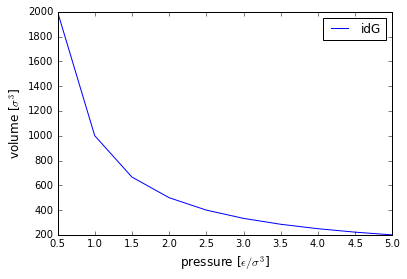

In [9]:
V = dict()

for job in project.find_jobs():
    V[job.statepoint()['p']] = job.document['V']
    
p = sorted(V.keys())
V = [V[p_] for p_ in p]

plt.plot(p, V, label='idG')
plt.xlabel(r'pressure [$\epsilon / \sigma^3$]')
plt.ylabel(r'volume [$\sigma^3$]')
plt.legend()

As a a final step, we ca generate a index of our project data:

In [10]:
for doc in project.index():
    print(doc)

{'statepoint': {'T': 1.0, 'N': 1000, 'p': 0.5}, 'signac_id': 'e04010d2a7c4b1727cd1a74c6f99b0b6', 'format': None, 'V': 2000.0, '_id': 'e04010d2a7c4b1727cd1a74c6f99b0b6'}
{'statepoint': {'T': 1.0, 'N': 1000, 'p': 2.0}, 'signac_id': '833d057b6f7f8e2a9939d48fa7ac4bf9', 'format': None, 'V': 500.0, '_id': '833d057b6f7f8e2a9939d48fa7ac4bf9'}
{'statepoint': {'T': 1.0, 'N': 1000, 'p': 4.0}, 'signac_id': '5ac448d5ef652f938bc2410d7f17819b', 'format': None, 'V': 250.0, '_id': '5ac448d5ef652f938bc2410d7f17819b'}
{'statepoint': {'T': 1.0, 'N': 1000, 'p': 1.0}, 'signac_id': '9e100da58ccdf6ad7941fce7d14deeb5', 'format': None, 'V': 1000.0, '_id': '9e100da58ccdf6ad7941fce7d14deeb5'}
{'statepoint': {'T': 1.0, 'N': 1000, 'p': 1.5}, 'signac_id': 'd30c9d7cb9496b0244d57c7af56b9388', 'format': None, 'V': 666.6666666666666, '_id': 'd30c9d7cb9496b0244d57c7af56b9388'}
{'statepoint': {'T': 1.0, 'N': 1000, 'p': 3.5}, 'signac_id': '4929455e6b8708ce249a3247538e3102', 'format': None, 'V': 285.7142857142857, '_id': '4